In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# 探討：
* 四種出場條件下的獲利情況
* 因為沒資料而出場的要另外考量

In [2]:
trade_result = pd.read_csv('trade_result_finance.csv')
trade_result['date_in'] = trade_result['date_in'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
trade_result['date_out'] = trade_result['date_out'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
trade_result['stock_1_profit'] = None
trade_result['stock_2_profit'] = None
trade_result['net_profit'] = None
trade_result.head()

,Unnamed: 0,ADF_statistic_in,ADF_statistic_out,ASR_in,ASR_out,PS_in,PS_out,date_in,date_out,hedge_ratio_in,...,stock_1_log_in,stock_1_log_out,stock_1_out,stock_2_in,stock_2_log_in,stock_2_log_out,stock_2_out,stock_1_profit,stock_2_profit,net_profit
0,"(2809, 2887)",-2.537345,NaN,2.271674,NaN,1.554106,NaN,2009-12-07,2009-12-14,2.370609,...,1.916923,NaN,6.72,6.01,1.793425,NaN,5.75,None,None,None
1,"(2816, 2883)",-2.124908,NaN,2.169104,NaN,1.101550,NaN,2009-12-07,2009-12-14,0.605361,...,3.475377,NaN,31.98,6.01,1.793425,NaN,6.00,None,None,None
2,"(2801, 2891)",-2.976270,NaN,1.744411,NaN,1.721530,NaN,2009-12-07,2009-12-21,1.815708,...,2.111425,NaN,7.96,8.61,2.152924,NaN,8.22,None,None,None
3,"(2809, 2888)",-2.123514,NaN,1.715060,NaN,1.068899,NaN,2009-12-07,2009-12-21,1.407970,...,1.916923,NaN,6.91,10.84,2.383243,NaN,9.91,None,None,None
4,"(2809, 2889)",-2.507929,NaN,1.737984,NaN,1.324117,NaN,2009-12-07,2009-12-28,1.484936,...,1.916923,NaN,6.87,5.55,1.713798,NaN,5.66,None,None,None


In [3]:
cost_rate = 0.001425
tax_rate = 0.003

In [4]:
def calculate_profit(x):
    if x['spread_in'] > 0:
        # buy stock_1, short stock_2
        stock_1_profit = (
            x['stock_1_out'] - x['stock_1_in'] -
            cost_rate*(x['stock_1_in']+x['stock_1_out']) -
            tax_rate*(x['stock_1_out'])
        )*abs(x['hedge_ratio_in'])
        stock_2_profit = (
            x['stock_2_in'] - x['stock_2_out'] -
            cost_rate*(x['stock_2_in']+x['stock_2_out']) -
            tax_rate*(x['stock_2_out'])
        )*1000
    else:
        # short stock_1, buy stock_2
        stock_1_profit = (
            x['stock_1_in'] - x['stock_1_out'] -
            cost_rate*(x['stock_1_in']+x['stock_1_out']) -
            tax_rate*(x['stock_1_out'])
        )*abs(x['hedge_ratio_in'])
        stock_2_profit = (
            x['stock_2_out'] - x['stock_2_in'] -
            cost_rate*(x['stock_2_in']+x['stock_2_out']) -
            tax_rate*(x['stock_2_out'])
        )*1000

    total_profit = stock_1_profit + stock_2_profit
    
    return [stock_1_profit, stock_2_profit, total_profit]

In [5]:
trade_result = trade_result.copy()
for i in range(len(trade_result)):
    temp_result = trade_result.iloc[i]
    trade_result.loc[i, ['stock_1_profit', 'stock_2_profit', 'net_profit']] = calculate_profit(temp_result)

In [6]:
trade_result.reason.unique()

array(['cointegration_invalid', 'reversion', 'take profit', 'stop_loss'], dtype=object)

In [7]:
def plot_equity_curve(select_result = 'take profit', figsize=(16, 8)):
    if select_result == None:
        temp_result = trade_result
        select_result = 'total result'
    else: 
        temp_result = trade_result[trade_result.reason == select_result]
    accumulate_profit = temp_result.net_profit.values.cumsum()

    # 找出創新高的index(要畫綠點)
    new_highest_index = []
    for i in range(len(accumulate_profit)):
        current_accumulate_profit = accumulate_profit[i]
        if i == 0:
            new_highest = accumulate_profit[i]
        if (current_accumulate_profit > new_highest) and (current_accumulate_profit > 0):
            new_highest = current_accumulate_profit
            new_highest_index.append(i)

    plt.style.use('seaborn')
    plt.figure(figsize=figsize)
    # 權益曲線
    plt.plot(accumulate_profit, c='black')
    # 創新高的點
    plt.scatter(new_highest_index,
                accumulate_profit[new_highest_index], c='#02ff0f', s=70)
    plt.title('Equity Curve - {}'.format(select_result), size=20)
    plt.xlabel('Trade Number', size=15)
    plt.ylabel('NTD', size=15)
    plt.xticks(size=13)
    plt.yticks(size=13);

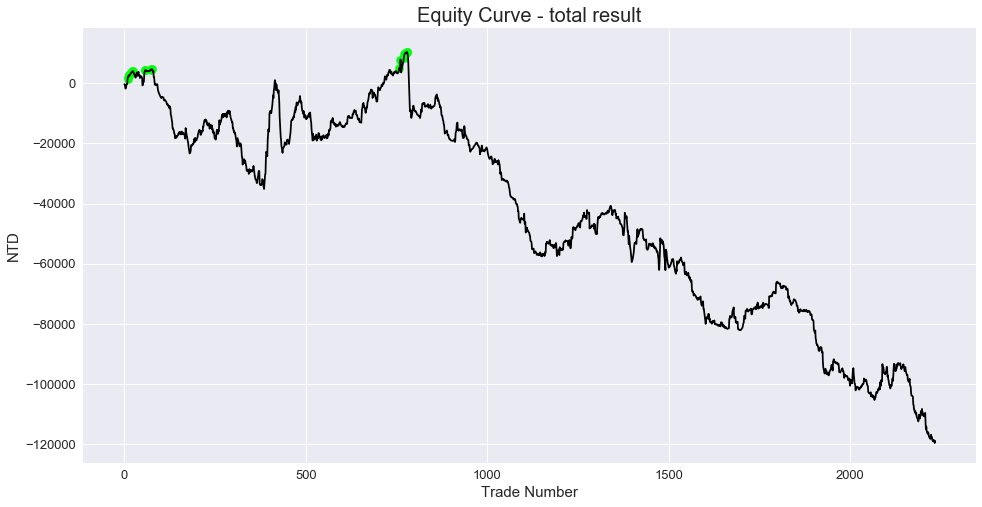

In [8]:
plot_equity_curve(None)

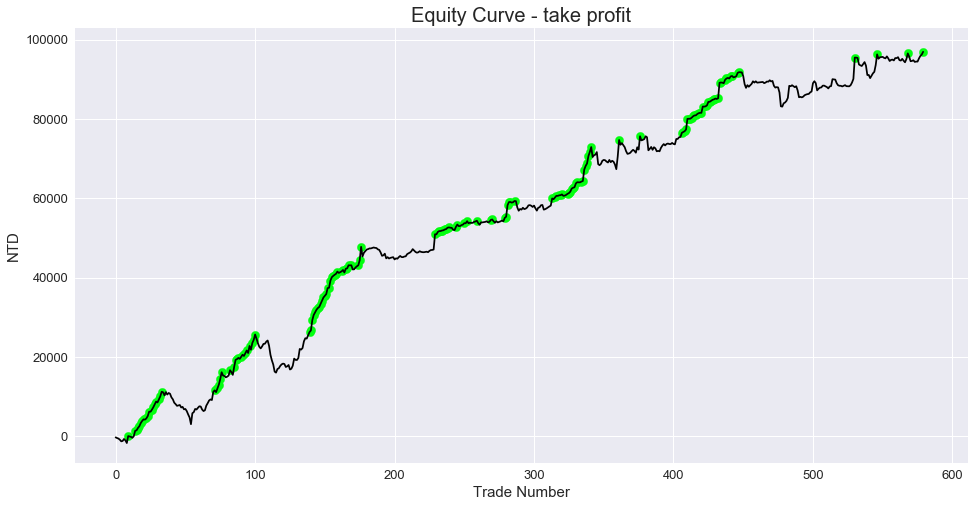

In [9]:
plot_equity_curve('take profit')

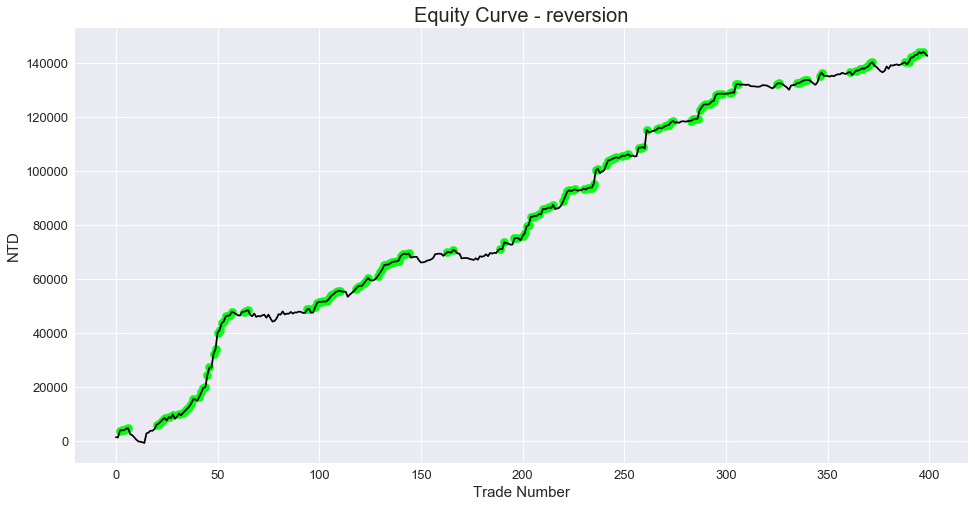

In [10]:
plot_equity_curve('reversion')

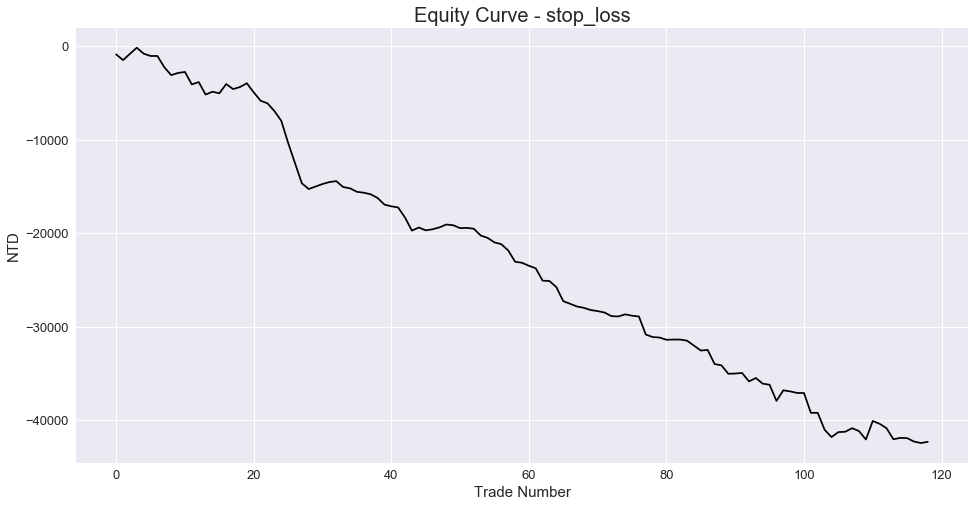

In [11]:
plot_equity_curve('stop_loss')

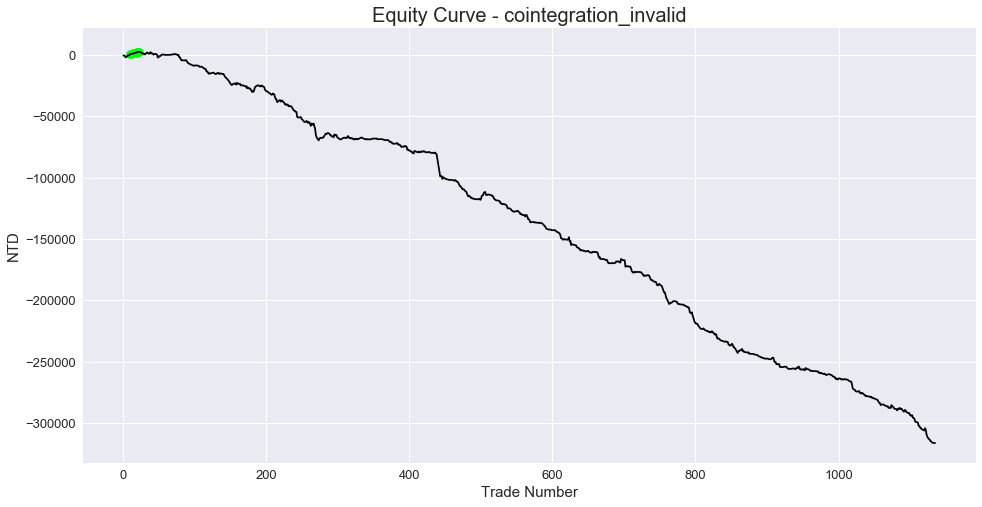

In [12]:
plot_equity_curve('cointegration_invalid')